<h2> Graph Convolutional Networks for Semi Supervised Node Classification</h2>

This code extends https://github.com/tkipf/gcn with snippets to visualize the graph, and t-sne visualizations of node embeddings, before and after the semi supervised training.<br>

We label ~1% or 27 points on the cora dataset and achieve a classification accuracy of ~55%. I have used a very simple model and there is lots of room for improvement

references:<br> 
https://arxiv.org/abs/1609.02907<br>
http://tkipf.github.io/graph-convolutional-networks/<br>

In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

from utils import normalize, sparse_mx_to_torch_sparse_tensor, accuracy
from scipy.sparse import csr_matrix, coo_matrix, diags,eye



In [2]:
# The GCN Architecture


class graph_convolution_layer(Module):

    def __init__(self, in_features, out_features):
        super(graph_convolution_layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = Parameter(torch.FloatTensor(out_features))
        self.weight.data.uniform_(-0.1, 0.1)
        self.bias.data.uniform_(-0.1, 0.1)


    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        return output + self.bias

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = graph_convolution_layer(nfeat, nhid)
        self.gc2 = graph_convolution_layer(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        embedding = x
        x = F.dropout(x, self.dropout, training=self.training)
        
        x = self.gc2(x, adj)
        return embedding, F.log_softmax(x, dim=1)


In [3]:
# Hyperparameters

seed = 42
epochs = 500
lr = 0.005
weight_decay = 5e-4
hidden = 64
dropout = 0.5

np.random.seed(seed)
torch.manual_seed(seed)


In [4]:
# Read and process data


nodes = np.genfromtxt("{}{}.content".format('data/cora/', 'cora'), dtype=np.dtype(str))
edges = np.genfromtxt("{}{}.cites".format('data/cora/', 'cora'), dtype=np.int32)


features = np.array(nodes[:, 1:-1], dtype = np.float32)
features = normalize(csr_matrix(features, dtype=np.float32))

labels = nodes[:, -1]
classes = np.unique(labels)
one_hot_classes = dict(zip(classes, np.squeeze(np.eye(len(classes))[list(range(len(classes)))])))
one_hot_labels = np.array([one_hot_classes[i] for i in labels])

idx = np.array(nodes[:, 0], dtype=np.int32)
idx_map = {j: i for i, j in enumerate(idx)}

edges = np.array(list(map(idx_map.get, edges.flatten())), dtype=np.int32).reshape(edges.shape)
adj = coo_matrix((np.ones(2*edges.shape[0]), (np.concatenate((edges[:, 0], edges[:, 1]), axis=0), np.concatenate((edges[:, 1], edges[:, 0]), axis=0))), shape=(labels.shape[0], labels.shape[0]), dtype=np.float32)


adj = adj + eye(adj.shape[0])
adj = coo_matrix(adj)
rowsum = np.array(adj.sum(1))
d_inv_sqrt = np.power(rowsum, -0.5).flatten()
d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
d_mat_inv_sqrt = diags(d_inv_sqrt)
adj = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo() # The good stuff

idx_train = range(27) # We label exactly 27 points, they contain all the classes
idx_val = range(27, 2500)
idx_test = range(27, 2500)

features = torch.FloatTensor(np.array(features.todense()))
labels = torch.LongTensor(np.where(one_hot_labels)[1])
adj = sparse_mx_to_torch_sparse_tensor(adj)

idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)



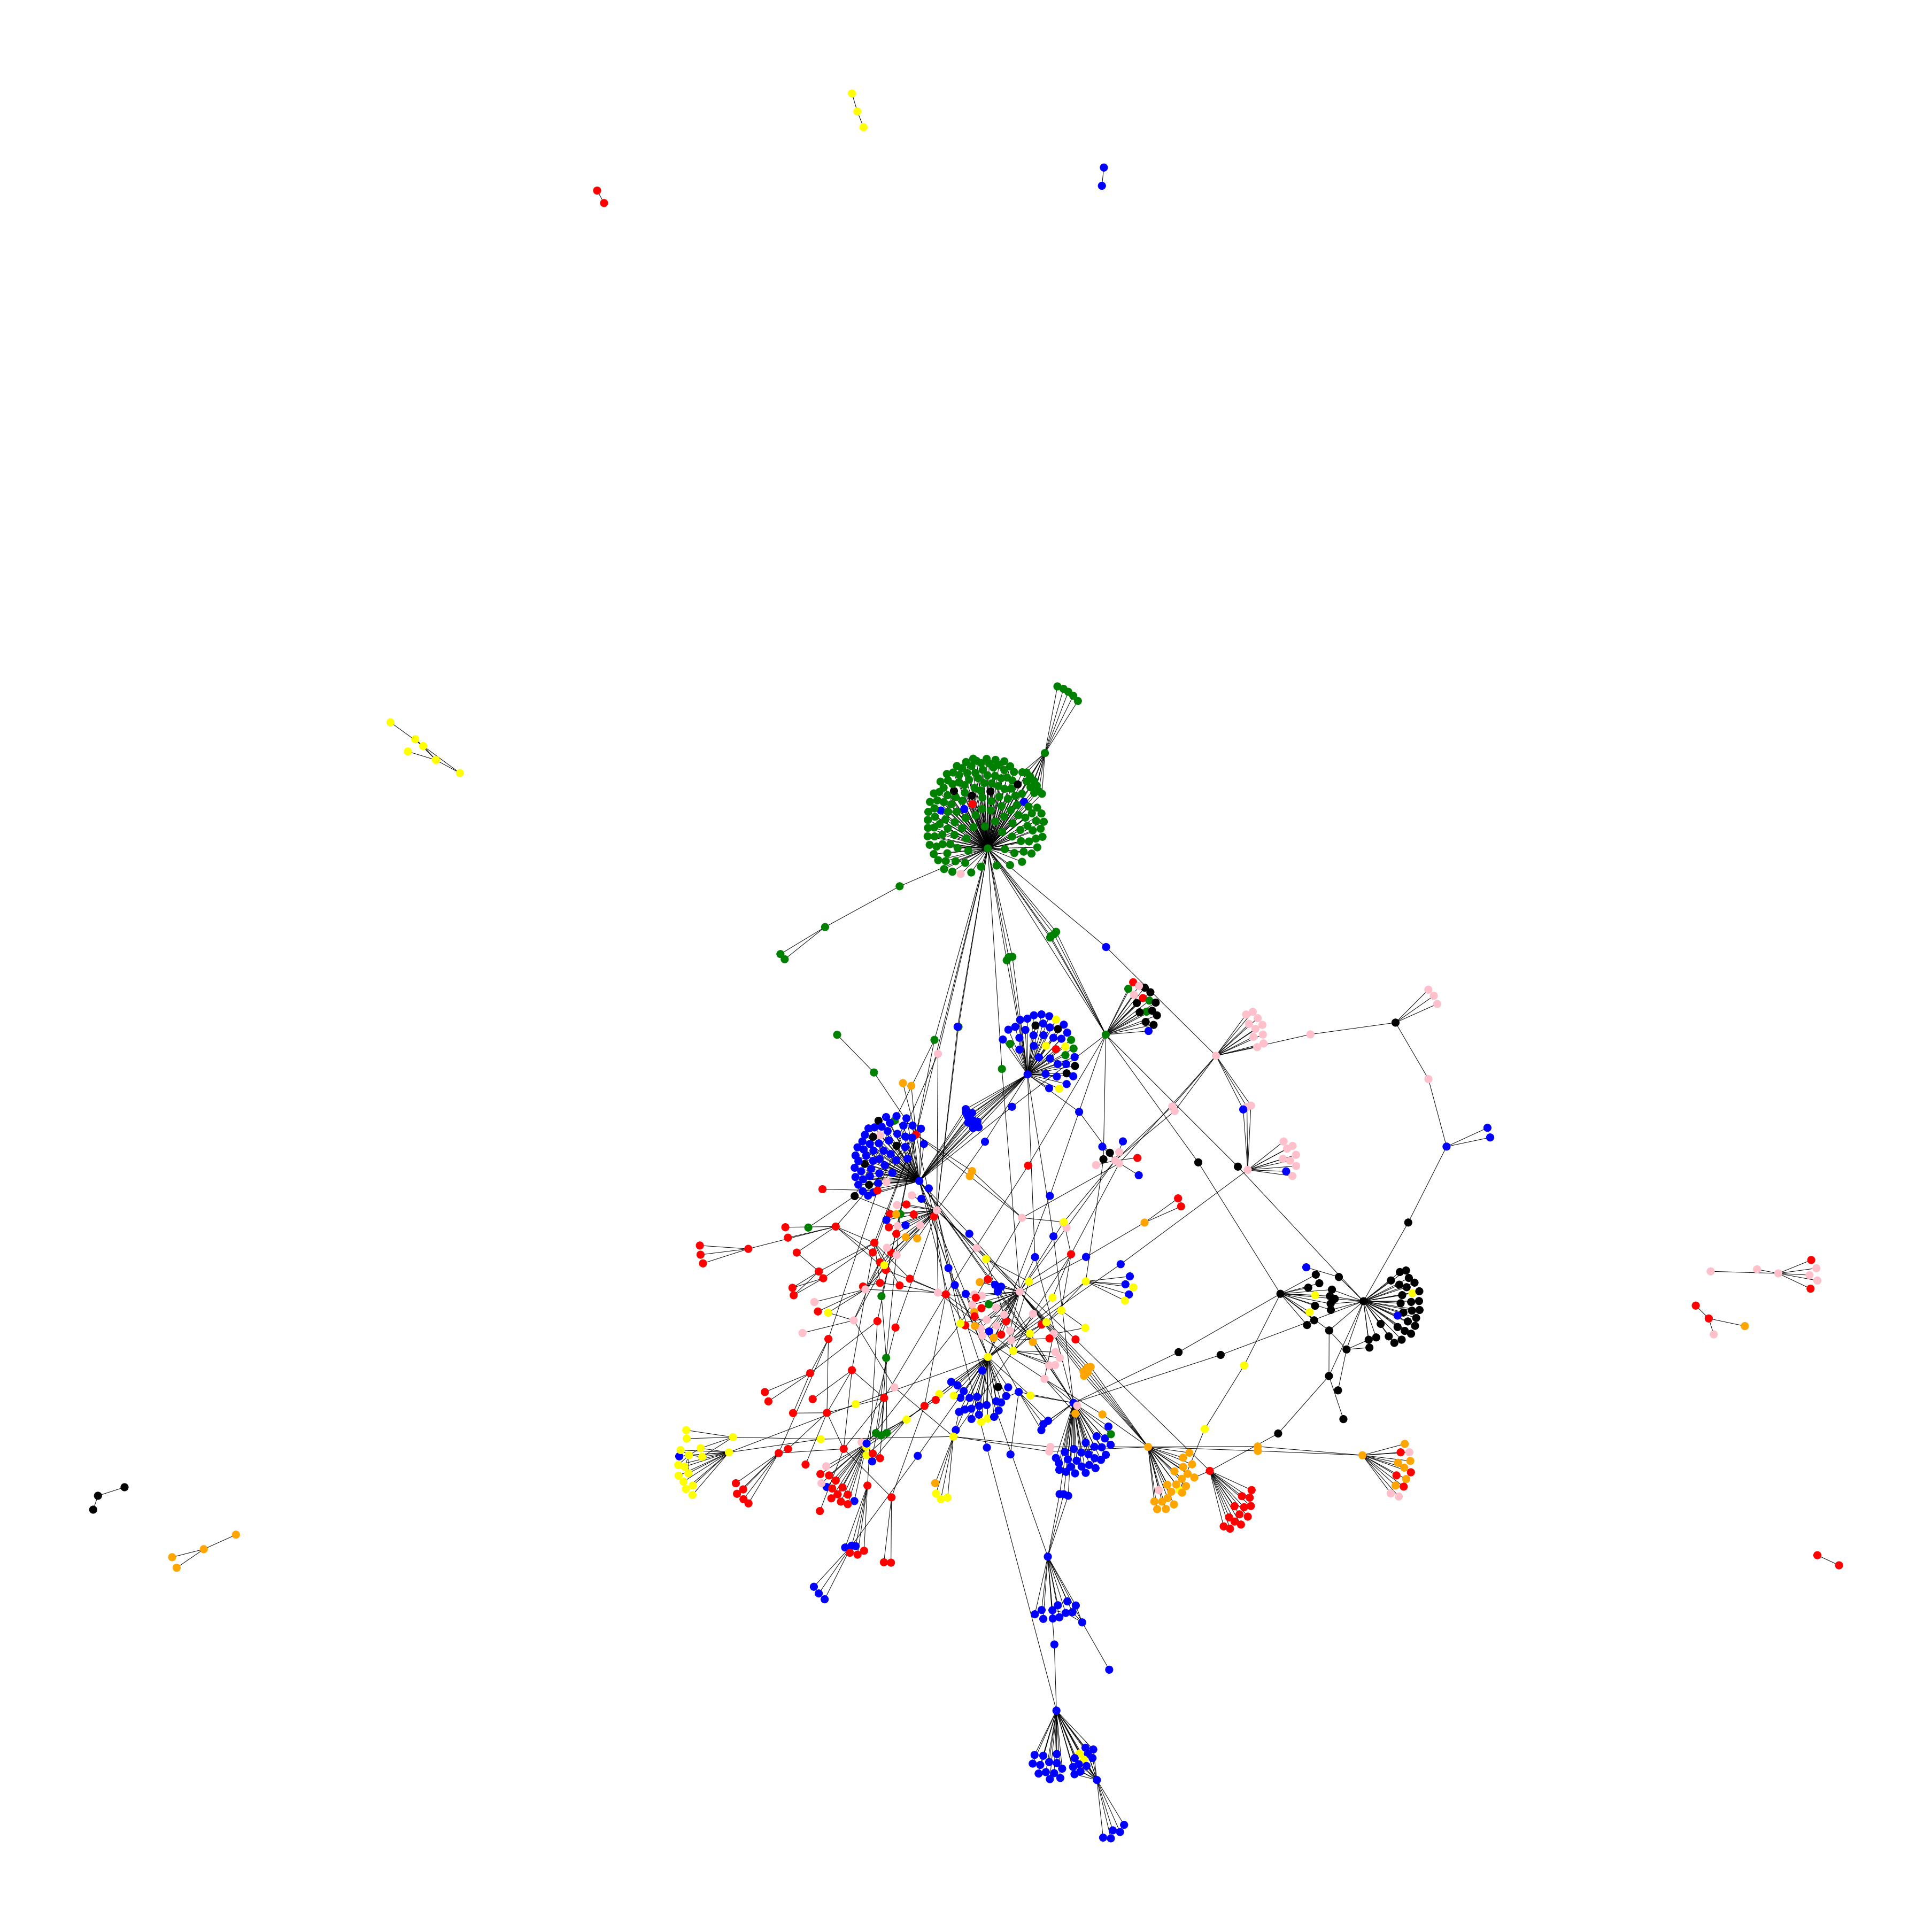

In [5]:
%matplotlib inline

# Visualize the cora dataset

import matplotlib.pyplot as plt
import networkx as nx

fig = plt.gcf()
fig.set_size_inches(50, 50)

G = nx.Graph()
G.add_edges_from(list(edges)[0:1000]) # sample 1000 edges

color_map = {0:'red', 1:'green', 2:'blue', 3:'yellow', 4:'black', 5:'orange', 6:'pink'}
colors = [color_map[i] for i in labels.numpy()[G.nodes()]]


nx.draw(G, node_size=200, node_color = colors)


plt.axis('off')
plt.show()

In [6]:
# Model and optimizer
model = GCN(nfeat=features.shape[1], nhid=hidden, nclass=labels.max().item() + 1, dropout=dropout)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


# Testing the model
def test():
    model.eval()
    embedding, output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))



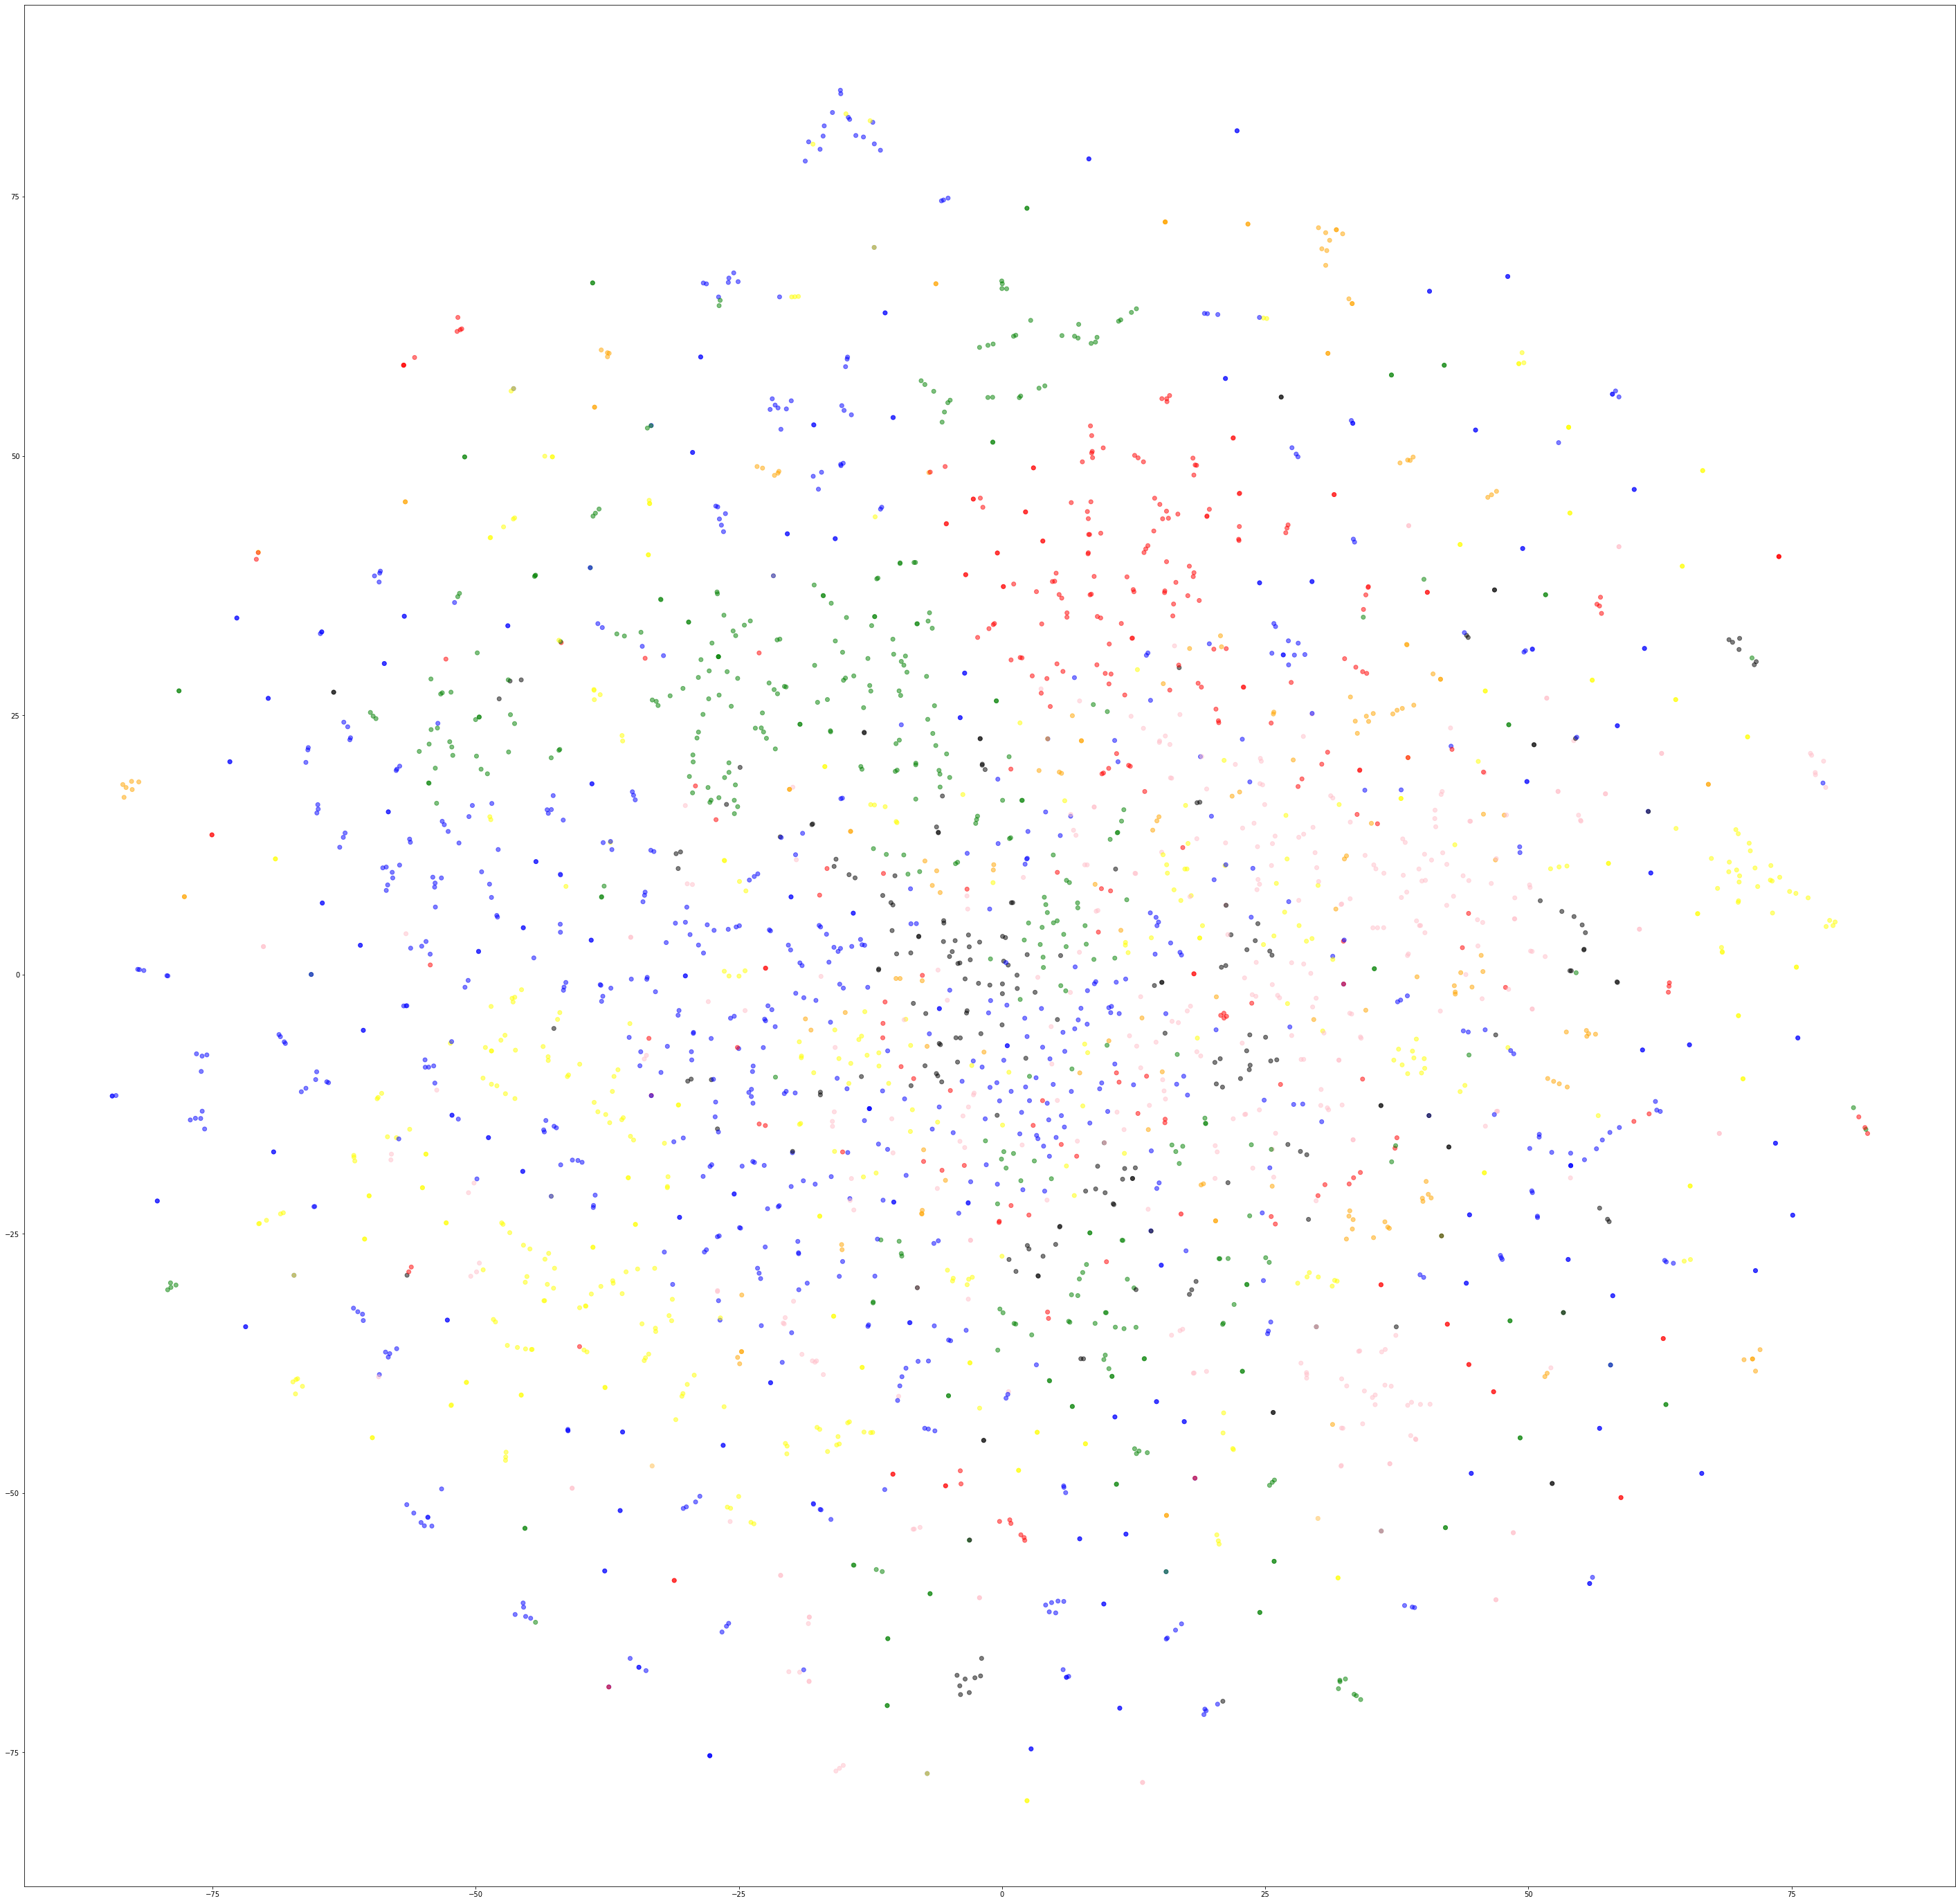

In [7]:
%matplotlib inline

# t-sne embeddings before the semi supervised training

# The classes are intermingled

embedding, output = model(features, adj)

import numpy as np
from sklearn.manifold import TSNE
X = np.array(embedding.detach().numpy())
X_embedded = TSNE(n_components=2).fit_transform(X)

fig = plt.gcf()
fig.set_size_inches(50, 50)


color_map = {0:'red', 1:'green', 2:'blue', 3:'yellow', 4:'black', 5:'orange', 6:'pink'}
colors = [color_map[i] for i in labels.numpy()]


plt.scatter(X_embedded.T[0], X_embedded.T[1], c = colors, alpha=0.5)
plt.show()

In [8]:

t_total = time.time()
for epoch in range(epochs):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    embedding, output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()


    model.eval()
    embedding, output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Testing
test()


Epoch: 0001 loss_train: 1.9479 acc_train: 0.1111 loss_val: 1.9404 acc_val: 0.1274 time: 0.1357s
Epoch: 0002 loss_train: 1.9362 acc_train: 0.0741 loss_val: 1.9361 acc_val: 0.1597 time: 0.1192s
Epoch: 0003 loss_train: 1.9244 acc_train: 0.2222 loss_val: 1.9320 acc_val: 0.2790 time: 0.1128s
Epoch: 0004 loss_train: 1.9165 acc_train: 0.3704 loss_val: 1.9280 acc_val: 0.2996 time: 0.0640s
Epoch: 0005 loss_train: 1.9013 acc_train: 0.3704 loss_val: 1.9241 acc_val: 0.2996 time: 0.0735s
Epoch: 0006 loss_train: 1.8866 acc_train: 0.3704 loss_val: 1.9202 acc_val: 0.2996 time: 0.1198s
Epoch: 0007 loss_train: 1.8795 acc_train: 0.3704 loss_val: 1.9164 acc_val: 0.2996 time: 0.0819s
Epoch: 0008 loss_train: 1.8637 acc_train: 0.3704 loss_val: 1.9126 acc_val: 0.2996 time: 0.1369s
Epoch: 0009 loss_train: 1.8455 acc_train: 0.3704 loss_val: 1.9089 acc_val: 0.2996 time: 0.0954s
Epoch: 0010 loss_train: 1.8319 acc_train: 0.3704 loss_val: 1.9053 acc_val: 0.2996 time: 0.0785s
Epoch: 0011 loss_train: 1.8189 acc_train

Epoch: 0086 loss_train: 0.6553 acc_train: 0.8519 loss_val: 1.6704 acc_val: 0.4100 time: 0.0688s
Epoch: 0087 loss_train: 0.6253 acc_train: 0.8519 loss_val: 1.6663 acc_val: 0.4096 time: 0.0893s
Epoch: 0088 loss_train: 0.5946 acc_train: 0.8519 loss_val: 1.6621 acc_val: 0.4108 time: 0.0642s
Epoch: 0089 loss_train: 0.6206 acc_train: 0.8889 loss_val: 1.6575 acc_val: 0.4133 time: 0.0619s
Epoch: 0090 loss_train: 0.5722 acc_train: 0.8519 loss_val: 1.6525 acc_val: 0.4169 time: 0.0459s
Epoch: 0091 loss_train: 0.6100 acc_train: 0.8519 loss_val: 1.6470 acc_val: 0.4189 time: 0.0471s
Epoch: 0092 loss_train: 0.5842 acc_train: 0.8519 loss_val: 1.6411 acc_val: 0.4201 time: 0.0501s
Epoch: 0093 loss_train: 0.5791 acc_train: 0.9259 loss_val: 1.6347 acc_val: 0.4226 time: 0.0700s
Epoch: 0094 loss_train: 0.5979 acc_train: 0.8519 loss_val: 1.6282 acc_val: 0.4242 time: 0.0663s
Epoch: 0095 loss_train: 0.5502 acc_train: 0.8889 loss_val: 1.6215 acc_val: 0.4246 time: 0.0712s
Epoch: 0096 loss_train: 0.5465 acc_train

Epoch: 0171 loss_train: 0.2440 acc_train: 0.9630 loss_val: 1.3612 acc_val: 0.5528 time: 0.0634s
Epoch: 0172 loss_train: 0.2728 acc_train: 0.9630 loss_val: 1.3580 acc_val: 0.5532 time: 0.0628s
Epoch: 0173 loss_train: 0.2499 acc_train: 0.9630 loss_val: 1.3560 acc_val: 0.5548 time: 0.0650s
Epoch: 0174 loss_train: 0.2460 acc_train: 0.9630 loss_val: 1.3551 acc_val: 0.5548 time: 0.0816s
Epoch: 0175 loss_train: 0.2480 acc_train: 0.9630 loss_val: 1.3550 acc_val: 0.5516 time: 0.0780s
Epoch: 0176 loss_train: 0.2412 acc_train: 0.9630 loss_val: 1.3556 acc_val: 0.5483 time: 0.0929s
Epoch: 0177 loss_train: 0.3123 acc_train: 0.9630 loss_val: 1.3562 acc_val: 0.5455 time: 0.1032s
Epoch: 0178 loss_train: 0.2665 acc_train: 1.0000 loss_val: 1.3571 acc_val: 0.5419 time: 0.0723s
Epoch: 0179 loss_train: 0.2445 acc_train: 1.0000 loss_val: 1.3576 acc_val: 0.5406 time: 0.0673s
Epoch: 0180 loss_train: 0.2901 acc_train: 0.9630 loss_val: 1.3572 acc_val: 0.5402 time: 0.0704s
Epoch: 0181 loss_train: 0.2115 acc_train

Epoch: 0256 loss_train: 0.1682 acc_train: 1.0000 loss_val: 1.3128 acc_val: 0.5673 time: 0.0525s
Epoch: 0257 loss_train: 0.1742 acc_train: 1.0000 loss_val: 1.3110 acc_val: 0.5681 time: 0.0728s
Epoch: 0258 loss_train: 0.1794 acc_train: 1.0000 loss_val: 1.3090 acc_val: 0.5689 time: 0.0549s
Epoch: 0259 loss_train: 0.1940 acc_train: 1.0000 loss_val: 1.3094 acc_val: 0.5693 time: 0.0552s
Epoch: 0260 loss_train: 0.1591 acc_train: 1.0000 loss_val: 1.3135 acc_val: 0.5661 time: 0.0591s
Epoch: 0261 loss_train: 0.1749 acc_train: 1.0000 loss_val: 1.3181 acc_val: 0.5649 time: 0.0776s
Epoch: 0262 loss_train: 0.2106 acc_train: 1.0000 loss_val: 1.3216 acc_val: 0.5605 time: 0.0740s
Epoch: 0263 loss_train: 0.1427 acc_train: 1.0000 loss_val: 1.3246 acc_val: 0.5560 time: 0.0652s
Epoch: 0264 loss_train: 0.1995 acc_train: 1.0000 loss_val: 1.3249 acc_val: 0.5568 time: 0.0598s
Epoch: 0265 loss_train: 0.1700 acc_train: 1.0000 loss_val: 1.3246 acc_val: 0.5580 time: 0.0623s
Epoch: 0266 loss_train: 0.1565 acc_train

Epoch: 0341 loss_train: 0.1153 acc_train: 1.0000 loss_val: 1.3042 acc_val: 0.5681 time: 0.0507s
Epoch: 0342 loss_train: 0.1183 acc_train: 1.0000 loss_val: 1.3122 acc_val: 0.5629 time: 0.0484s
Epoch: 0343 loss_train: 0.1351 acc_train: 1.0000 loss_val: 1.3199 acc_val: 0.5572 time: 0.0461s
Epoch: 0344 loss_train: 0.1762 acc_train: 1.0000 loss_val: 1.3220 acc_val: 0.5544 time: 0.0565s
Epoch: 0345 loss_train: 0.1524 acc_train: 1.0000 loss_val: 1.3218 acc_val: 0.5540 time: 0.0502s
Epoch: 0346 loss_train: 0.1688 acc_train: 1.0000 loss_val: 1.3172 acc_val: 0.5564 time: 0.0559s
Epoch: 0347 loss_train: 0.1083 acc_train: 1.0000 loss_val: 1.3141 acc_val: 0.5572 time: 0.0590s
Epoch: 0348 loss_train: 0.1304 acc_train: 1.0000 loss_val: 1.3123 acc_val: 0.5596 time: 0.0811s
Epoch: 0349 loss_train: 0.1399 acc_train: 1.0000 loss_val: 1.3095 acc_val: 0.5609 time: 0.0559s
Epoch: 0350 loss_train: 0.1467 acc_train: 1.0000 loss_val: 1.3056 acc_val: 0.5649 time: 0.0545s
Epoch: 0351 loss_train: 0.1005 acc_train

Epoch: 0426 loss_train: 0.1189 acc_train: 1.0000 loss_val: 1.3208 acc_val: 0.5475 time: 0.0491s
Epoch: 0427 loss_train: 0.1326 acc_train: 1.0000 loss_val: 1.3246 acc_val: 0.5447 time: 0.0509s
Epoch: 0428 loss_train: 0.0961 acc_train: 1.0000 loss_val: 1.3227 acc_val: 0.5459 time: 0.0534s
Epoch: 0429 loss_train: 0.1082 acc_train: 1.0000 loss_val: 1.3190 acc_val: 0.5475 time: 0.0668s
Epoch: 0430 loss_train: 0.1147 acc_train: 1.0000 loss_val: 1.3156 acc_val: 0.5516 time: 0.0563s
Epoch: 0431 loss_train: 0.1178 acc_train: 1.0000 loss_val: 1.3113 acc_val: 0.5584 time: 0.0436s
Epoch: 0432 loss_train: 0.1201 acc_train: 1.0000 loss_val: 1.3102 acc_val: 0.5584 time: 0.0443s
Epoch: 0433 loss_train: 0.0875 acc_train: 1.0000 loss_val: 1.3101 acc_val: 0.5609 time: 0.0796s
Epoch: 0434 loss_train: 0.1083 acc_train: 1.0000 loss_val: 1.3083 acc_val: 0.5641 time: 0.0660s
Epoch: 0435 loss_train: 0.0930 acc_train: 1.0000 loss_val: 1.3094 acc_val: 0.5653 time: 0.0538s
Epoch: 0436 loss_train: 0.1022 acc_train

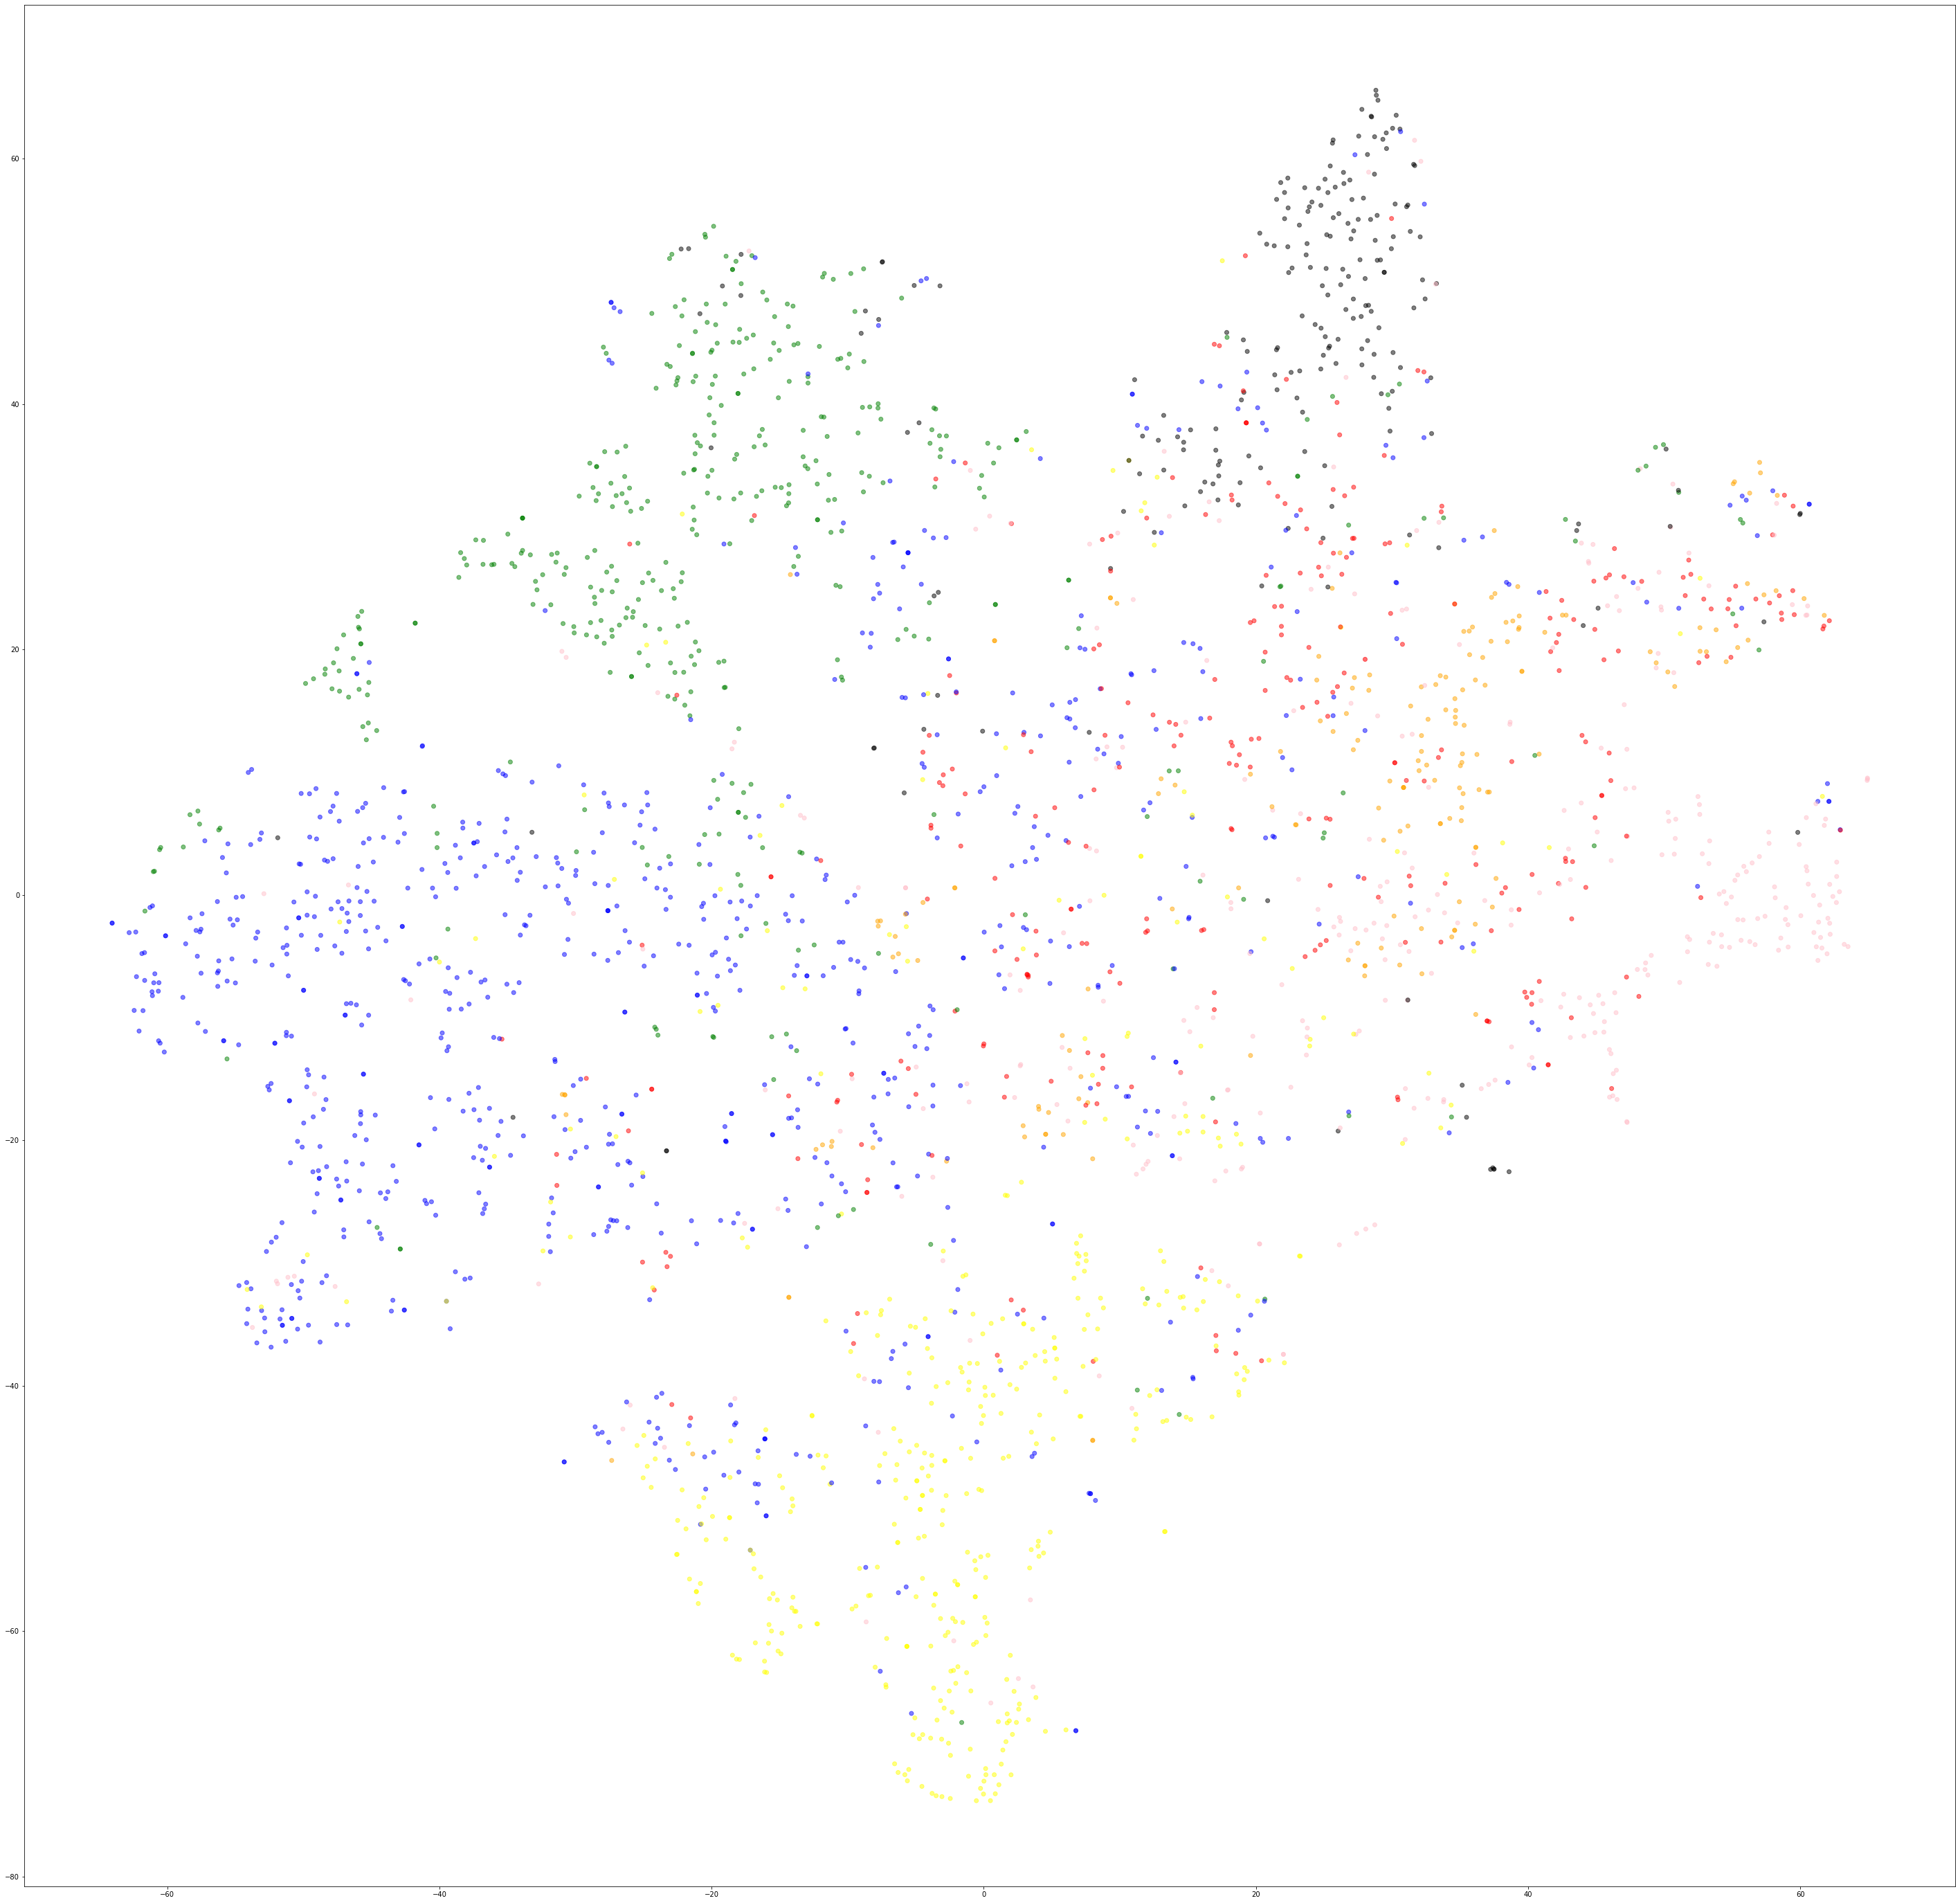

In [9]:
%matplotlib inline

# After training - the classes seem to be well separated out

embedding, output = model(features, adj)

import numpy as np
from sklearn.manifold import TSNE
X = np.array(embedding.detach().numpy())
X_embedded = TSNE(n_components=2).fit_transform(X)

fig = plt.gcf()
fig.set_size_inches(50, 50)


color_map = {0:'red', 1:'green', 2:'blue', 3:'yellow', 4:'black', 5:'orange', 6:'pink'}
colors = [color_map[i] for i in labels.numpy()]


plt.scatter(X_embedded.T[0], X_embedded.T[1], c = colors, alpha=0.5)
plt.show()